# 02.Coding Assignment - GloVe


Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-26 10:33:21.019142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 10:33:22.732872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 10:33:22.733018: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libn

## 1. Load data / try real corpus
Dataset import from NLTK library 

In [2]:
import nltk 
from nltk.corpus import brown, inaugural
nltk.download('punkt')
nltk.download('brown')
nltk.download('inaugural')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!


True

In [3]:
corpus_tokenized = nltk.corpus.brown.sents(categories='mystery')

In [4]:
#test around 800 words only due GPU speed
corpus_tokenized = corpus_tokenized[0:800]
corpus_tokenized

[['There', 'were', 'thirty-eight', 'patients', 'on', 'the', 'bus', 'the', 'morning', 'I', 'left', 'for', 'Hanover', ',', 'most', 'of', 'them', 'disturbed', 'and', 'hallucinating', '.'], ['An', 'interne', ',', 'a', 'nurse', 'and', 'two', 'attendants', 'were', 'in', 'charge', 'of', 'us', '.'], ...]

In [5]:
#1. tokenize
corpus_tokenized = [[word.lower() for word in sent] for sent in corpus_tokenized]
print(corpus_tokenized[:2])

[['there', 'were', 'thirty-eight', 'patients', 'on', 'the', 'bus', 'the', 'morning', 'i', 'left', 'for', 'hanover', ',', 'most', 'of', 'them', 'disturbed', 'and', 'hallucinating', '.'], ['an', 'interne', ',', 'a', 'nurse', 'and', 'two', 'attendants', 'were', 'in', 'charge', 'of', 'us', '.']]


In [6]:
#1. tokenize reference
# import spacy
# nlp = spacy.load("en_core_web_sm")
# tokenize = nlp("I eat apple.")

# for i in tokenize:
#     print(i.text)

In [75]:
#2. numericalize #assign id to all this vocabs #add <UNK> word 
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
word2index = {v: idx for idx, v in enumerate(vocabs)}

vocabs.append('<UNK>')

#vocab size
voc_size = len(vocabs)
print(voc_size)

#3. create index2word dictionary   
index2word = {v:k for k, v in word2index.items()}
index2word

vocabs

2147


['phone',
 'coffee',
 'automatic',
 'long',
 'comes',
 'grab',
 'frightened',
 'lot',
 'parking',
 'red-clay',
 'youth',
 'relative',
 'off',
 'neared',
 'crazy',
 'howling',
 'could',
 'mary',
 'listening',
 'interne',
 'look',
 'sped',
 'dismally',
 'if',
 'mister',
 'tissue',
 'cracker-box',
 'promises',
 'drink',
 'however',
 'unblinkingly',
 '&',
 'gone',
 'gets',
 "that's",
 ';',
 'acting',
 'each',
 'stalls',
 'dollar',
 'laid',
 'punctured',
 'forced',
 'going',
 'lips',
 'blank',
 'genuine',
 'them',
 'held',
 'officially',
 'easily',
 'quick',
 'communication',
 'painfully',
 'foolishly',
 'lost',
 'companion',
 'coast',
 'office',
 'roadway',
 'spiked',
 'within',
 'liquor',
 'porch',
 'five',
 'competence',
 'squire',
 'known',
 'own',
 'someone',
 'gas',
 'identification',
 'two',
 'bristled',
 'run',
 'appear',
 'roll',
 'drag',
 'highway',
 'on',
 'yet',
 'scaring',
 'lines',
 'turkey',
 'landis',
 'endless',
 'gangster',
 'taste',
 'started',
 'furnished',
 'bowed',
 'k

In [76]:

len(corpus_tokenized)

800

## 2. Co-occurrence matrix X

Count the occurrences of pair of words using window size of 1 (you can use 2, 3, 4, up to you.)

E.g., Dog loves to eat meat.     

['dog', 'loves', 1], ['loves', 'to', 1]

In [77]:
from collections import Counter

X_i = Counter(flatten(corpus_tokenized)) # X_i
X_i

Counter({'there': 54,
         'were': 38,
         'thirty-eight': 1,
         'patients': 2,
         'on': 112,
         'the': 633,
         'bus': 5,
         'morning': 2,
         'i': 218,
         'left': 15,
         'for': 65,
         'hanover': 8,
         ',': 450,
         'most': 4,
         'of': 198,
         'them': 28,
         'disturbed': 1,
         'and': 276,
         'hallucinating': 1,
         '.': 688,
         'an': 28,
         'interne': 1,
         'a': 251,
         'nurse': 2,
         'two': 24,
         'attendants': 1,
         'in': 152,
         'charge': 2,
         'us': 5,
         'felt': 14,
         'lonely': 3,
         'depressed': 2,
         'as': 65,
         'stared': 5,
         'out': 60,
         'window': 7,
         'at': 83,
         "chicago's": 2,
         'grim': 1,
         'dirty': 1,
         'west': 5,
         'side': 19,
         'it': 119,
         'seemed': 10,
         'incredible': 1,
         'listened': 3,
       

In [78]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus_tokenized:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

skip_grams

[('were', 'there'),
 ('were', 'thirty-eight'),
 ('thirty-eight', 'were'),
 ('thirty-eight', 'patients'),
 ('patients', 'thirty-eight'),
 ('patients', 'on'),
 ('on', 'patients'),
 ('on', 'the'),
 ('the', 'on'),
 ('the', 'bus'),
 ('bus', 'the'),
 ('bus', 'the'),
 ('the', 'bus'),
 ('the', 'morning'),
 ('morning', 'the'),
 ('morning', 'i'),
 ('i', 'morning'),
 ('i', 'left'),
 ('left', 'i'),
 ('left', 'for'),
 ('for', 'left'),
 ('for', 'hanover'),
 ('hanover', 'for'),
 ('hanover', ','),
 (',', 'hanover'),
 (',', 'most'),
 ('most', ','),
 ('most', 'of'),
 ('of', 'most'),
 ('of', 'them'),
 ('them', 'of'),
 ('them', 'disturbed'),
 ('disturbed', 'them'),
 ('disturbed', 'and'),
 ('and', 'disturbed'),
 ('and', 'hallucinating'),
 ('hallucinating', 'and'),
 ('hallucinating', '.'),
 ('interne', 'an'),
 ('interne', ','),
 (',', 'interne'),
 (',', 'a'),
 ('a', ','),
 ('a', 'nurse'),
 ('nurse', 'a'),
 ('nurse', 'and'),
 ('and', 'nurse'),
 ('and', 'two'),
 ('two', 'and'),
 ('two', 'attendants'),
 ('atte

In [79]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('were', 'there'): 5,
         ('were', 'thirty-eight'): 1,
         ('thirty-eight', 'were'): 1,
         ('thirty-eight', 'patients'): 1,
         ('patients', 'thirty-eight'): 1,
         ('patients', 'on'): 1,
         ('on', 'patients'): 1,
         ('on', 'the'): 44,
         ('the', 'on'): 45,
         ('the', 'bus'): 4,
         ('bus', 'the'): 4,
         ('the', 'morning'): 1,
         ('morning', 'the'): 1,
         ('morning', 'i'): 1,
         ('i', 'morning'): 1,
         ('i', 'left'): 1,
         ('left', 'i'): 1,
         ('left', 'for'): 2,
         ('for', 'left'): 2,
         ('for', 'hanover'): 1,
         ('hanover', 'for'): 1,
         ('hanover', ','): 3,
         (',', 'hanover'): 3,
         (',', 'most'): 1,
         ('most', ','): 1,
         ('most', 'of'): 3,
         ('of', 'most'): 3,
         ('of', 'them'): 5,
         ('them', 'of'): 5,
         ('them', 'disturbed'): 1,
         ('disturbed', 'them'): 1,
         ('disturbed', 'and'): 1,
   

## 3. Weighting function f

GloVe includes a weighting function to scale down too frequent words.

In [80]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [81]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocabs, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

#print(f"{X_ik=}")
#print(f"{weighting_dic=}")

## 4. Prepare train data

In [82]:
  
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

In [83]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)



#we will convert them to tensor during training, so don't worry...

Input:  [[ 421]
 [1342]]
Target:  [[1163]
 [1537]]
Cooc:  [[1.09861229]
 [0.69314718]]
Weighting:  [[0.07208434]
 [0.05318296]]


## 5.Model and Training


##### *GLoVe

In [16]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## tain the model in here

batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")



Epoch: 1000 | cost: 28.823656 | time: 0m 0s
Epoch: 2000 | cost: 21.513199 | time: 0m 0s
Epoch: 3000 | cost: 12.911075 | time: 0m 0s
Epoch: 4000 | cost: 1.231903 | time: 0m 0s
Epoch: 5000 | cost: 2.063946 | time: 0m 0s


##### GloVe-plot the embedding

In [17]:
#list of vocabs
vocabs[:10]

word = vocabs[0]

#numericalization
id = word2index[word]
id

#longTensor
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [18]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.1432, grad_fn=<SelectBackward0>)

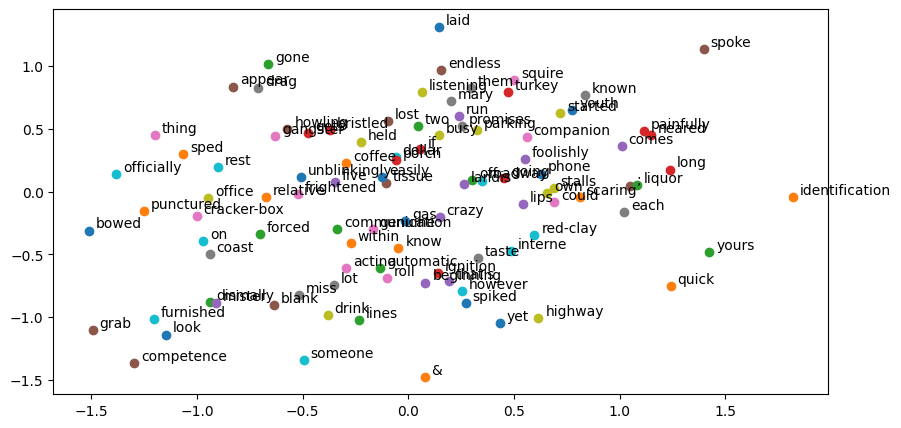

In [19]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:100]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

#### *Skipgram / CBOWS
##### This part inspired from the Word2vec

In [84]:
skipgrams = []
cbows = []
#for each corpus
for sent in corpus_tokenized:
  
    for i in range(2, len(sent) - 2): #start from 1 to second last
        center_word = sent[i]
        outside_word = [sent[i-2],sent[i-1],sent[i+1],sent[i+2]] #window_size = 2
        for o in outside_word:
            skipgrams.append([center_word, o])
        cbows.append([center_word, outside_word])

corpus_tokenized[0]  

['there',
 'were',
 'thirty-eight',
 'patients',
 'on',
 'the',
 'bus',
 'the',
 'morning',
 'i',
 'left',
 'for',
 'hanover',
 ',',
 'most',
 'of',
 'them',
 'disturbed',
 'and',
 'hallucinating',
 '.']

In [85]:
#let's make what we have made into a function (batch function)
def random_batch(batch_size, corpus):
    
    skipgrams = []
    cbows = []
    #for each corpus
    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+2]]]  #window_size = 2
            for o in outside_words:
                skipgrams.append([center_word, o])
            cbows.append([center_word, outside_word])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][1]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][0]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [86]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[1394],
       [ 298],
       [ 323],
       [ 881],
       [ 679],
       [2021],
       [ 129],
       [ 324],
       [1810],
       [1253]])


### start with skipgram first

In [88]:
voc_size = len(vocabs)
voc_size

2147

In [90]:
word2index['<UNK>'] = 6

In [ ]:
#preparing all_vocabs

bbatch_size = 2 #why? no reason
emb_size = 2 #usually, this can be 50, 100, or 300
model = skipgrams(voc_size, emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [91]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 2147])

In [92]:
class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [93]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 6.429402 | Time: ??
Epoch 2000 | Loss: 6.704234 | Time: ??
Epoch 3000 | Loss: 8.257387 | Time: ??
Epoch 4000 | Loss: 6.126914 | Time: ??
Epoch 5000 | Loss: 19.960392 | Time: ??


#### *CBOWS
##### This part inspired from the Word2vec

In [97]:
#preparing all_vocabs

bbatch_size = 2 #why? no reason
emb_size = 2 #usually, this can be 50, 100, or 300
model = cbows(voc_size, emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [98]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 2147])

In [99]:
#the model will accept three vectors - u_o, v_c, u_w
#u_o - vector for outside words
#v_c - vector for center word
#u_w - vectors of all vocabs

class cbows(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(cbows, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [101]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 8.898018 | Time: ??
Epoch 2000 | Loss: 6.868834 | Time: ??
Epoch 3000 | Loss: 11.048557 | Time: ??
Epoch 4000 | Loss: 5.737856 | Time: ??
Epoch 5000 | Loss: 2.913125 | Time: ??


#### Skipgram / Negative sampling
##### This part inspired from the Word2vec


In [102]:
z = 0.001  #scaling up low frequency terms
#count all the occurrences of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

num_total_words = sum([c for w, c in word_count.items()])
num_total_words


11722

In [103]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
Counter(unigram_table)

Counter({'phone': 3,
         'coffee': 1,
         'automatic': 1,
         'long': 3,
         'frightened': 1,
         'lot': 2,
         'parking': 4,
         'red-clay': 1,
         'off': 6,
         'crazy': 1,
         'could': 11,
         'mary': 3,
         'listening': 1,
         'look': 2,
         'sped': 1,
         'if': 11,
         'drink': 3,
         'gone': 3,
         'gets': 2,
         "that's": 5,
         ';': 7,
         'acting': 1,
         'each': 2,
         'laid': 1,
         'forced': 1,
         'going': 9,
         'them': 10,
         'held': 2,
         'lost': 2,
         'companion': 2,
         'office': 4,
         'roadway': 1,
         'within': 1,
         'liquor': 1,
         'porch': 1,
         'five': 1,
         'squire': 2,
         'known': 2,
         'own': 2,
         'someone': 2,
         'two': 9,
         'run': 3,
         'highway': 1,
         'on': 30,
         'yet': 2,
         'landis': 2,
         'started': 3,
    

In [104]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]




In [105]:
#preparing all_vocabs

bbatch_size = 2 #why? no reason
emb_size = 2 #usually, this can be 50, 100, or 300
model = SkipgramNeg(voc_size, emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [106]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 2147])

In [108]:
#Modeling here

class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [109]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 30.964476 | Time: ??
Epoch 2000 | Loss: 242.742630 | Time: ??
Epoch 3000 | Loss: 91.077888 | Time: ??
Epoch 4000 | Loss: 0.427125 | Time: ??
Epoch 5000 | Loss: 0.736463 | Time: ??


## Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words
#### #Try other dataset recommended by Our TA

In [122]:
# Import datasets
import pandas as pd
path = 'wordsim_similarity_goldstandard.txt'
df = pd.read_table(path, header=None)
df.head()

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77


In [123]:
synthetic_test_set = df.iloc[:10]
synthetic_test_set

,0,1,2
0,tiger,cat,7.35
1,tiger,tiger,10.00
2,plane,car,5.77
3,train,car,6.31
4,television,radio,6.77
5,media,radio,7.42
6,bread,butter,6.19
7,cucumber,potato,5.92
8,doctor,nurse,7.00
9,professor,doctor,6.62


In [1]:
#...

## Summary
- The accuracy might not working well event GloVe is computationally efficient and requires less data but may not be as accurate  because it is based on co-occurrence statistics and model, which can't capture subtle and complex relationships between words.
- For CBOW is fast to train than Skip-Gram, but the embeddings produced by CBOW may not be as accurate. 
- GloVe is computationally efficient and requires less data. It is computationally efficient and requires less data than CBOW or Skip-Gram. GloVe embeddings are similar to those produced by CBOW and Skip-Gram but may be less accurate.
- SkipgramNeg is faster than Skip-Gram while still producing high-quality word embeddings.